In [1]:
pip install --upgrade typing_extensions


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
from datasets import Dataset, load_dataset, DatasetDict, load_from_disk
import os

In [2]:
from transformers import AutoTokenizer
tabibert_tokenizer = AutoTokenizer.from_pretrained('boun-tabilab/TabiBERT')

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/970 [00:00<?, ?B/s]

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import gc
from sklearn.preprocessing import LabelEncoder

multiple_of_value = 128

def display_qa_length_distribution(ds, tokenizer, split='validation', show_histogram=True):
    """
    Read a QA dataset and display the distribution of tokenized example lengths.
    
    Args:
        ds: DatasetDict or Dataset containing QA data with 'context' and 'question' fields
        tokenizer: Tokenizer to use for encoding
        split: Which split to analyze ('train', 'validation', 'test', or 'all')
        show_histogram: Whether to display a histogram plot
    """
    # Handle both DatasetDict and single Dataset
    if isinstance(ds, dict) or hasattr(ds, 'keys'):
        if split == 'all':
            # Combine all splits
            all_examples = []
            for split_name in ds.keys():
                all_examples.extend([ex for ex in ds[split_name]])
            dataset_name = 'all splits'
        else:
            if split not in ds:
                available = list(ds.keys())
                raise ValueError(f"Split '{split}' not found. Available splits: {available}")
            all_examples = [ex for ex in ds[split]]
            dataset_name = f"'{split}' split"
    else:
        # Single dataset
        all_examples = [ex for ex in ds]
        dataset_name = 'dataset'

    print(f"Analyzing {len(all_examples):,} examples from {dataset_name}")
    print("-" * 60)

    # Calculate tokenized lengths
    lengths = []
    for example in all_examples:
        # Combine context and question (same as in determine_quantile_values_qa)
        combined_text = example['context'] + " " + example['question']
        tokenized_length = len(tokenizer.encode(combined_text))
        lengths.append(tokenized_length)

    lengths = np.array(lengths)

    # Calculate statistics
    print(f"\nToken Length Statistics:")
    print(f"  Total examples: {len(lengths):,}")
    print(f"  Mean: {np.mean(lengths):.2f}")
    print(f"  Median: {np.median(lengths):.2f}")
    print(f"  Std Dev: {np.std(lengths):.2f}")
    print(f"  Min: {np.min(lengths):,}")
    print(f"  Max: {np.max(lengths):,}")
    print(f"\nPercentiles:")
    print(f"  25th: {int(np.percentile(lengths, 25)):,}")
    print(f"  50th (Median): {int(np.percentile(lengths, 50)):,}")
    print(f"  75th: {int(np.percentile(lengths, 75)):,}")
    print(f"  90th: {int(np.percentile(lengths, 90)):,}")
    print(f"  95th: {int(np.percentile(lengths, 95)):,}")
    print(f"  98th: {int(np.percentile(lengths, 98)):,}")
    print(f"  99th: {int(np.percentile(lengths, 99)):,}")
    print(f"  99.9th: {int(np.percentile(lengths, 99.9)):,}")

    # Show histogram if requested
    if show_histogram:
        plt.figure(figsize=(12, 6))

        # Create subplot for histogram
        plt.subplot(1, 2, 1)
        plt.hist(lengths, bins=50, edgecolor='black', alpha=0.7)
        plt.xlabel('Tokenized Length (context + question)')
        plt.ylabel('Frequency')
        plt.title(f'Distribution of Tokenized Lengths\n({dataset_name})')
        plt.grid(True, alpha=0.3)

        # Add vertical lines for key statistics
        plt.axvline(np.mean(lengths), color='red', linestyle='--', label=f'Mean: {np.mean(lengths):.1f}')
        plt.axvline(np.median(lengths), color='green', linestyle='--', label=f'Median: {np.median(lengths):.1f}')
        plt.axvline(np.percentile(lengths, 95), color='orange', linestyle='--',
                   label=f'95th: {int(np.percentile(lengths, 95))}')
        plt.legend()

        # Create subplot for box plot
        plt.subplot(1, 2, 2)
        plt.boxplot(lengths, vert=True)
        plt.ylabel('Tokenized Length (context + question)')
        plt.title(f'Box Plot of Tokenized Lengths\n({dataset_name})')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    return lengths


Analyzing 14,221 examples from 'train' split
------------------------------------------------------------

Token Length Statistics:
  Total examples: 14,221
  Mean: 296.94
  Median: 234.00
  Std Dev: 256.06
  Min: 20
  Max: 2,484

Percentiles:
  25th: 137
  50th (Median): 234
  75th: 363
  90th: 573
  95th: 802
  98th: 991
  99th: 1,473
  99.9th: 2,473


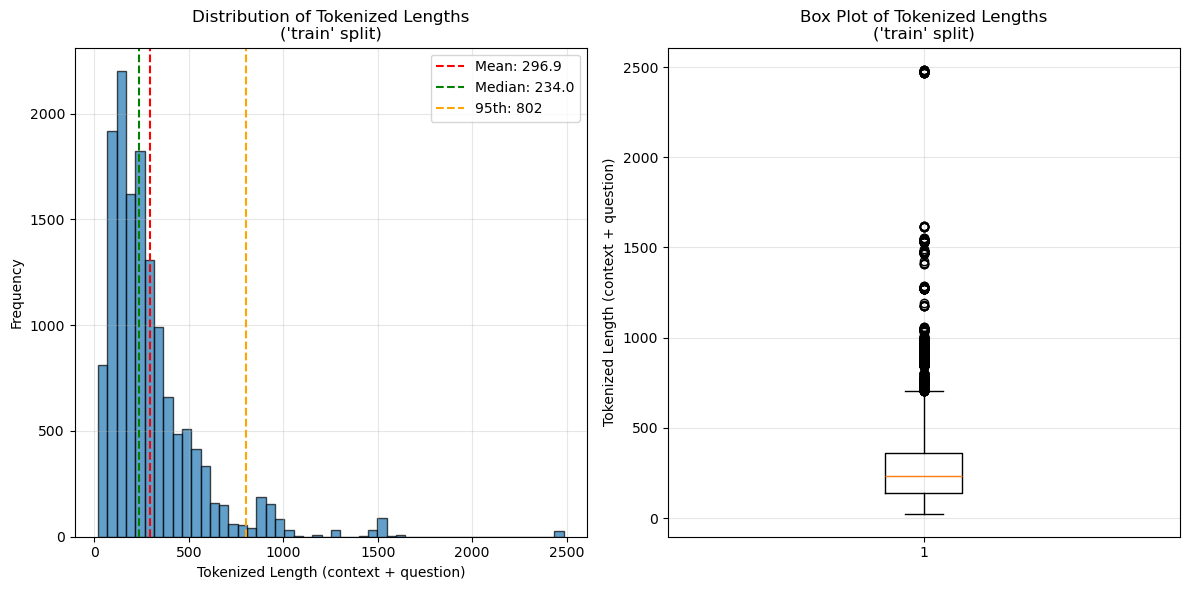

Analyzing 2,520 examples from 'validation' split
------------------------------------------------------------

Token Length Statistics:
  Total examples: 2,520
  Mean: 285.31
  Median: 185.00
  Std Dev: 340.72
  Min: 29
  Max: 2,799

Percentiles:
  25th: 133
  50th (Median): 185
  75th: 282
  90th: 582
  95th: 1,005
  98th: 1,836
  99th: 1,838
  99.9th: 2,783


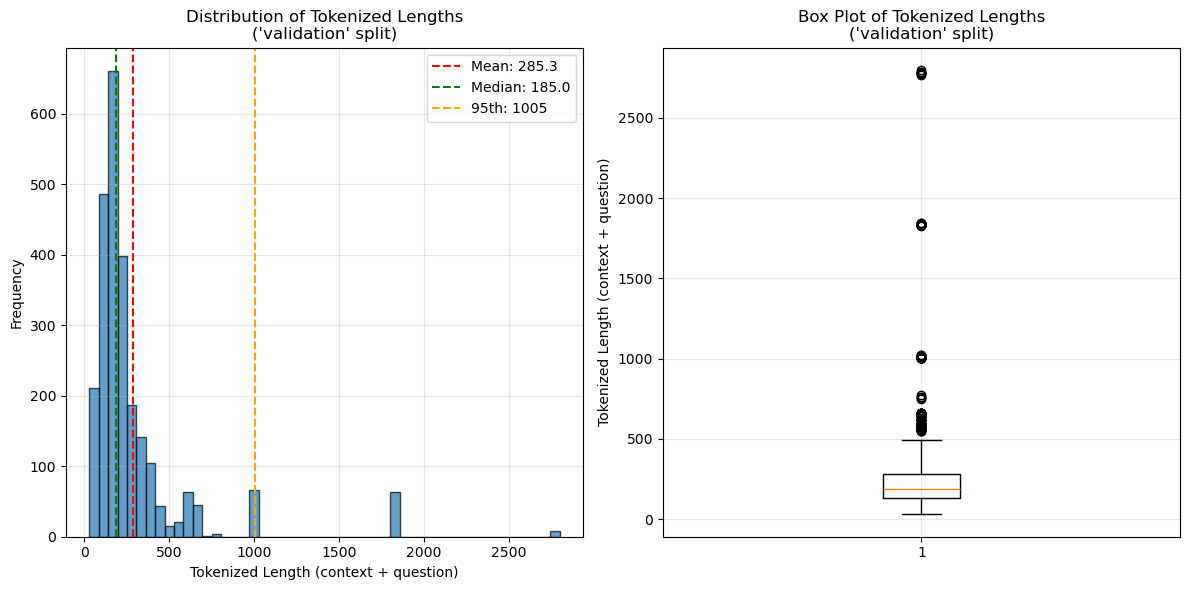

array([332, 339, 336, ..., 394, 400, 298])

In [9]:
tquad_qa = load_dataset("erdometo/tquad2")
tquad_qa

display_qa_length_distribution(tquad_qa,
                               tabibert_tokenizer,
                               split='train',
                               show_histogram=True)
print("="*50)
display_qa_length_distribution(tquad_qa, tabibert_tokenizer, split='validation', show_histogram=True)

In [3]:
import numpy as np
import gc
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer
tabibert_tokenizer = AutoTokenizer.from_pretrained('boun-tabilab/TabiBERT')

multiple_of_value = 128
def determine_quantile_values(ds):
    X_train = [example['text'] for example in ds['train']]
    X_test = [example['text'] for example in ds['test']]
    y_train = [example['label'] for example in ds['train']]
    y_test = [example['label'] for example in ds['test']]
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.transform(y_test)
    
    num_labels = len(np.unique(y_train))
    print(f'Number of labels: {num_labels:,}')
    
    lens = np.array([len(tabibert_tokenizer.encode(text)) for text in X_train])
    quantile_value_95 = int(np.quantile(lens, q=0.95))
    quantile_value_98 = int(np.quantile(lens, q=0.98))
    quantile_value_99 = int(np.quantile(lens, q=0.99))
    # Round to upper value to be a multiple of multiple value
    print(f'.95, .98, .99, .999: {quantile_value_95:,} & {quantile_value_98:,} & {quantile_value_99:,}')
    quantile_value_98 += multiple_of_value - quantile_value_98%multiple_of_value
    max_len = quantile_value_98
    print(f'Selected maximum length for the dataset: {max_len:,}')


def determine_quantile_values_token_class(ds):
    # Extract tokens and tags
    X_train = [example['tokens'] for example in ds['train']]
    X_test = [example['tokens'] for example in ds['test']]
    y_train = [example['tags'] for example in ds['train']]
    y_test = [example['tags'] for example in ds['test']]

    # Flatten tags to fit_label_encoder (optional)
    all_tags = [tag for tag_seq in y_train + y_test for tag in tag_seq]
    label_encoder = LabelEncoder()
    label_encoder.fit(all_tags)

    # Encode tags (optional, not used for quantiles)
    y_train_encoded = [label_encoder.transform(tags) for tags in y_train]
    y_test_encoded = [label_encoder.transform(tags) for tags in y_test]

    # Determine sequence lengths based on tokenized input length
    lens = np.array([len(tokens) for tokens in X_train])

    quantile_value_95 = int(np.quantile(lens, q=0.95))
    quantile_value_98 = int(np.quantile(lens, q=0.98))
    quantile_value_99 = int(np.quantile(lens, q=0.99))
    print(f'.95, .98, .99: {quantile_value_95:,} & {quantile_value_98:,} & {quantile_value_99:,}')
    
    # Round up to nearest multiple of multiple_of_value
    quantile_value_98 += multiple_of_value - quantile_value_98 % multiple_of_value
    max_len = quantile_value_98
    print(f'Selected maximum sequence length for the dataset: {max_len:,}')

In [4]:
from sklearn.model_selection import train_test_split

def dataset_analyzer(name: str):
    print(f'###### The {name} dataset:')
    if name == 'news_cat':
        news_cat = load_dataset("mcemilg/news-cat")
    elif name == 'wiki_ner':
        wiki_dataset = load_dataset('turkish-nlp-suite/turkish-wikiNER')
        # print(wiki_dataset)
        ds = wiki_dataset
        determine_quantile_values_token_class(ds)
        print('\n----------------------------\n')
        return
    elif name == 'xtreme_ner':
        xtreme_dataset = load_dataset("google/xtreme", "PAN-X.tr")
        # print(xtreme_dataset)
        # Rename data colum names: 
        xtreme_dataset['train'] = xtreme_dataset['train'].rename_columns({
            'ner_tags': 'tags'
        })
        xtreme_dataset['validation'] = xtreme_dataset['validation'].rename_columns({
            'ner_tags': 'tags'
        })
        xtreme_dataset['test'] = xtreme_dataset['test'].rename_columns({
            'ner_tags': 'tags'
        })
        ds = xtreme_dataset
        determine_quantile_values_token_class(ds)
        print('\n----------------------------\n')
        return
    determine_quantile_values(ds)
    print('\n----------------------------\n')

In [5]:
tweet_news = load_dataset("ctoraman/BilTweetNews-sentiment-analysis")['train']
tweet_news = tweet_news.rename_columns({
        'Text': 'text',
        'Majority': 'label',
        "TweetID" : 'id',
    })

tweet_news = tweet_news.remove_columns(
    [col for col in tweet_news.column_names if col not in ["text", "label", "id"]]
)

# Define mapping
label2id = {
    'Multi': 0,
    'Negative': 1,
    'Neutral': 2,
    'Positive': 3,
    'Sarcastic': 4
}

tweet_news = tweet_news.map(lambda x: {"label": label2id[x["label"]]})

ds = DatasetDict({
    'train': tweet_news,
    'test': tweet_news,
})
determine_quantile_values(ds)

README.md: 0.00B [00:00, ?B/s]

BilTweetNews_Sentiment.tsv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/995 [00:00<?, ? examples/s]

Map:   0%|          | 0/995 [00:00<?, ? examples/s]

Number of labels: 5
.95, .98, .99, .999: 55 & 60 & 63
Selected maximum length for the dataset: 128


In [11]:
tweet_news['train'][1]

{'Unnamed: 0': 1,
 'TweetNo': 2,
 'TweetID': 745383269517037568,
 'Date': 'Wed Jun 22 01:29:54 EEST 2016',
 'Text': 'RT @AylinAtaoglu: Bu marşın hangi sözleri hangi gayri MİLLİ insan müsveddesini rahatsız etti?10uncu YılMarşı https://t.co/FsCiGrpuG8',
 'Negative': 1.0,
 'Neutral': 0.0,
 'Positive': 0.0,
 'Sarcastic': 0.0,
 'Majority': 'Negative'}

In [15]:
set(tweet_news['train']['Majority'])

{'Multi', 'Negative', 'Neutral', 'Positive', 'Sarcastic'}

In [29]:
hate_speech_dataset = load_dataset("ctoraman/gender-hate-speech-turkish")
hate_speech_dataset['train'] = hate_speech_dataset['train'].rename_columns({
    'Text': 'text',
    'Label': 'label',
})
hate_speech_dataset['test'] = hate_speech_dataset['test'].rename_columns({
    'Text': 'text',
    'Label': 'label',
})
hate_speech_dataset
split_dataset = hate_speech_dataset['train'].train_test_split(test_size=0.1, seed=25)
train_dataset, eval_dataset = split_dataset['train'], split_dataset['test']
test_dataset = hate_speech_dataset['test']
ds = DatasetDict({
    'train': train_dataset,
    'eval': eval_dataset,
    'test': test_dataset,
})
determine_quantile_values(ds)

Number of labels: 3
.95, .98, .99, .999: 93 & 104 & 114
Selected maximum length for the dataset: 128


In [27]:
set(hate_speech_dataset['train']['label'])

{0, 1, 2}

In [7]:
dataset_analyzer('offensive')

###### The offensive dataset:
DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 31277
    })
})
Number of labels: 2
Selected maximum length for the dataset: 128

----------------------------



In [53]:
dataset_analyzer('news_cat')
dataset_analyzer('offensive')
dataset_analyzer('ttc4900')
dataset_analyzer('irony_tr')
dataset_analyzer('wiki_ner')
dataset_analyzer('xtreme_ner')

###### The news_cat dataset:
Number of labels: 5
Selected maximum length for the dataset: 1,280

----------------------------

###### The offensive dataset:
Number of labels: 2
Selected maximum length for the dataset: 128

----------------------------

###### The ttc4900 dataset:
Number of labels: 7
Selected maximum length for the dataset: 1,280

----------------------------

###### The irony_tr dataset:
Number of labels: 2
Selected maximum length for the dataset: 128

----------------------------

###### The wiki_ner dataset:
Selected maximum sequence length for the dataset: 128

----------------------------

###### The xtreme_ner dataset:
Selected maximum sequence length for the dataset: 128

----------------------------



In [13]:
import sys
import csv
def fix_csv_field_limit():
    """Increase the CSV field size limit to handle large text fields"""
    # Get the maximum possible field size for your system
    maxInt = sys.maxsize
    
    while True:
        # decrease the maxInt value by factor 10 
        # as long as the OverflowError occurs.
        try:
            csv.field_size_limit(maxInt)
            break
        except OverflowError:
            maxInt = int(maxInt/10)
    
    print(f"CSV field size limit set to: {csv.field_size_limit()}")

# Apply the fix before loading the dataset
fix_csv_field_limit()

CSV field size limit set to: 9223372036854775807


In [26]:
sts_dataset = load_dataset("emrecan/stsb-mt-turkish")

README.md:   0%|          | 0.00/566 [00:00<?, ?B/s]

train.csv: 0.00B [00:00, ?B/s]

dev.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

In [27]:
sts_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'score'],
        num_rows: 5749
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'score'],
        num_rows: 1500
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'score'],
        num_rows: 1379
    })
})

In [33]:
print(min(set(sts_dataset['train']['score'])))
print(max(set(sts_dataset['train']['score'])))

print(min(set(sts_dataset['validation']['score'])))
print(max(set(sts_dataset['validation']['score'])))

print(min(set(sts_dataset['test']['score'])))
print(max(set(sts_dataset['test']['score'])))

0.0
5.0
0.0
5.0
0.0
5.0


In [3]:
wiki_dataset = load_dataset("turkish-nlp-suite/turkish-wikiNER")
wiki_dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 17967
    })
    validation: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 1000
    })
})

In [12]:
train_set = wiki_dataset['train']
unique_tags = set(tag for row in train_set for tag in row['tags'])
tag2id = {tag: i for i, tag in enumerate(sorted(unique_tags))}
print(len(tag2id))
tag2id

39


{'B-CARDINAL': 0,
 'B-DATE': 1,
 'B-EVENT': 2,
 'B-FAC': 3,
 'B-GPE': 4,
 'B-LANGUAGE': 5,
 'B-LAW': 6,
 'B-LOC': 7,
 'B-MONEY': 8,
 'B-NORP': 9,
 'B-ORDINAL': 10,
 'B-ORG': 11,
 'B-PERCENT': 12,
 'B-PERSON': 13,
 'B-PRODUCT': 14,
 'B-QUANTITY': 15,
 'B-TIME': 16,
 'B-TITLE': 17,
 'B-WORK_OF_ART': 18,
 'I-CARDINAL': 19,
 'I-DATE': 20,
 'I-EVENT': 21,
 'I-FAC': 22,
 'I-GPE': 23,
 'I-LANGUAGE': 24,
 'I-LAW': 25,
 'I-LOC': 26,
 'I-MONEY': 27,
 'I-NORP': 28,
 'I-ORDINAL': 29,
 'I-ORG': 30,
 'I-PERCENT': 31,
 'I-PERSON': 32,
 'I-PRODUCT': 33,
 'I-QUANTITY': 34,
 'I-TIME': 35,
 'I-TITLE': 36,
 'I-WORK_OF_ART': 37,
 'O': 38}

In [18]:
ner_milliyet = load_dataset("datasets/ner-milliyet/")
ner_milliyet

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 22338
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 2482
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 2751
    })
})

In [24]:
ner_tags = set()
for tags in ner_milliyet['train']['ner_tags']:
    ner_tags.update(tags)
for tags in ner_milliyet['validation']['ner_tags']:
    ner_tags.update(tags)
for tags in ner_milliyet['test']['ner_tags']:
    ner_tags.update(tags)
ner_tags

{'B-LOCATION',
 'B-ORGANIZATION',
 'B-PERSON',
 'I-LOCATION',
 'I-ORGANIZATION',
 'I-PERSON',
 'O'}

In [23]:
# AutoModelForQuestionAnswering :
xtreme_pos = load_dataset("google/xtreme", 'udpos.Turkish')
xtreme_pos

DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tags'],
        num_rows: 3664
    })
    validation: Dataset({
        features: ['tokens', 'pos_tags'],
        num_rows: 988
    })
    test: Dataset({
        features: ['tokens', 'pos_tags'],
        num_rows: 4785
    })
})

In [24]:
unique_tags = set()
for tags in xtreme_pos['validation']['pos_tags']:
    unique_tags.update(tags)
unique_tags

{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 15, 16}

In [8]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

def determine_quantile_values_pos_dataset(ds, multiple_of_value=8):
    """
    Determine optimal sequence length for POS dataset based on quantiles.
    
    Args:
        ds: Dataset with 'train', 'test', and optionally 'validation' splits
        multiple_of_value: Round up max_length to nearest multiple of this value
    
    Returns:
        dict: Contains quantile values and selected max_length
    """
    
    # Extract tokens and POS tags - fixed field names
    X_train = [example['tokens'] for example in ds['train']]
    X_test = [example['tokens'] for example in ds['test']]
    y_train = [example['pos_tags'] for example in ds['train']]  # Changed from 'tags'
    y_test = [example['pos_tags'] for example in ds['test']]    # Changed from 'tags'
    
    # Include validation set if available
    if 'validation' in ds:
        X_val = [example['tokens'] for example in ds['validation']]
        y_val = [example['pos_tags'] for example in ds['validation']]
        X_train.extend(X_val)
        y_train.extend(y_val)
    
    # Flatten POS tags for label encoding (optional analysis)
    all_pos_tags = [tag for tag_seq in y_train + y_test for tag in tag_seq]
    label_encoder = LabelEncoder()
    label_encoder.fit(all_pos_tags)
    
    print(f"Number of unique POS tags: {len(label_encoder.classes_)}")
    print(f"POS tag classes: {label_encoder.classes_}")
    
    # Calculate sequence lengths for all splits
    train_lens = np.array([len(tokens) for tokens in X_train])
    test_lens = np.array([len(tokens) for tokens in X_test])
    all_lens = np.concatenate([train_lens, test_lens])
    
    # Calculate quantiles
    quantile_95 = int(np.quantile(all_lens, q=0.95))
    quantile_98 = int(np.quantile(all_lens, q=0.98))
    quantile_99 = int(np.quantile(all_lens, q=0.99))
    max_length = int(np.max(all_lens))
    mean_length = int(np.mean(all_lens))
    median_length = int(np.median(all_lens))
    
    print(f"Sequence length statistics:")
    print(f"  Mean: {mean_length}")
    print(f"  Median: {median_length}")
    print(f"  95th percentile: {quantile_95}")
    print(f"  98th percentile: {quantile_98}")
    print(f"  99th percentile: {quantile_99}")
    print(f"  Maximum: {max_length}")
    
    # Round up 98th percentile to nearest multiple
    if quantile_98 % multiple_of_value != 0:
        selected_max_len = quantile_98 + (multiple_of_value - quantile_98 % multiple_of_value)
    else:
        selected_max_len = quantile_98
    
    print(f"\nSelected maximum sequence length: {selected_max_len}")
    print(f"Percentage of sequences that will be truncated: {(all_lens > selected_max_len).mean() * 100:.2f}%")
    
    return {
        'quantile_95': quantile_95,
        'quantile_98': quantile_98,
        'quantile_99': quantile_99,
        'max_length': max_length,
        'mean_length': mean_length,
        'median_length': median_length,
        'selected_max_len': selected_max_len,
        'label_encoder': label_encoder,
        'num_pos_tags': len(label_encoder.classes_)
    }

In [25]:
determine_quantile_values_pos_dataset(xtreme_pos, 128)

Number of unique POS tags: 16
POS tag classes: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16]
Sequence length statistics:
  Mean: 9
  Median: 7
  95th percentile: 24
  98th percentile: 30
  99th percentile: 34
  Maximum: 57

Selected maximum sequence length: 128
Percentage of sequences that will be truncated: 0.00%


{'quantile_95': 24,
 'quantile_98': 30,
 'quantile_99': 34,
 'max_length': 57,
 'mean_length': 9,
 'median_length': 7,
 'selected_max_len': 128,
 'label_encoder': LabelEncoder(),
 'num_pos_tags': 16}

In [3]:
def determine_quantile_values_qa(ds, tokenizer):
    """
    Determine quantile values for QA dataset based on context + question length
    """
    # Extract contexts and questions from training data
    train_texts = []
    for example in ds['validation']:
        # Combine context and question for total input length
        combined_text = example['context'] + " " + example['question']
        train_texts.append(combined_text)
    
    # Calculate token lengths
    lens = np.array([len(tokenizer.encode(text)) for text in train_texts])
    
    print(f'Total training examples: {len(train_texts):,}')
    print(f'Token length stats:')
    print(f'  Mean: {np.mean(lens):.1f}')
    print(f'  Median: {np.median(lens):.1f}')
    print(f'  Max: {np.max(lens):,}')
    
    # Calculate quantiles
    quantile_value_95 = int(np.quantile(lens, q=0.95))
    quantile_value_98 = int(np.quantile(lens, q=0.98))
    quantile_value_99 = int(np.quantile(lens, q=0.99))
    
    print(f'Quantiles - 95th: {quantile_value_95:,}, 98th: {quantile_value_98:,}, 99th: {quantile_value_99:,}')
    
    # Round 95th percentile to multiple of multiple_of_value
    quantile_value_95 += multiple_of_value - quantile_value_95 % multiple_of_value
    max_len = quantile_value_95
    
    print(f'Selected maximum length for the dataset: {max_len:,}')
    
    return max_len

In [5]:
xtreme_qa = load_dataset("google/xtreme", 'XQuAD.tr')
xtreme_qa

README.md: 0.00B [00:00, ?B/s]

XQuAD.tr/validation-00000-of-00001.parqu(…):   0%|          | 0.00/228k [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/1190 [00:00<?, ? examples/s]

DatasetDict({
    validation: Dataset({
        features: ['id', 'context', 'question', 'answers'],
        num_rows: 1190
    })
})

In [7]:
xtreme_qa['validation'][1]

{'id': '56beb4343aeaaa14008c925c',
 'context': "\ufeffPanthers savunması ligdeki derecesi altıncı sırada olarak sadece 308 sayı bıraktı, aynı zamanda NFL'de 24 topu kapma ile ligin başını çekmesi ve dört Pro Bowl seçmeleri ile övünç duydu. Pro Bowl orta çizgi savunmacısı Kawann Short, takımı 11'le birlikte sack ederken, aynı zamanda üç oyuncuyu düşürme ve iki yeniden savunmaya zorladı. Yan hakem Mario Addison, 6½ sack ekledi. Panthers hattında ayrıca, sadece 9 başlangıçta 5 sack eden uç çizgi savunmacısı Kony Ealy ile birlikte 136 kez ile NFL'nin aktif kariyer sack lideri ve 5 kez profesyonel bir top atıcısı olan Jared Allen öne çıkmaktadır. Arkalarında, Panthers'lerin üç adet ikinci hat savunma oyuncusundan ikisi de Pro Bowl'da oynamak için seçildi: Thomas Davis ve Luke Kuechly. Davis, dördünde mecburi oyuncuyu düşürme ve dört topu kapma olmak üzere 5½ sack etmeyi bir araya getirirken, Kuechly top çalmalarda (118) iki mecburi oyuncuyu düşürme ve kendi başına dört pasını kesme ile takı

In [11]:
determine_quantile_values_qa(xtreme_qa, tabibert_tokenizer)

Total training examples: 1,190
Token length stats:
  Mean: 191.6
  Median: 169.0
  Max: 590
Quantiles - 95th: 341, 98th: 469, 99th: 558
Selected maximum length for the dataset: 512


512

In [8]:
qa_dataset = load_dataset("erdometo/tquad2")

In [9]:
qa_dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answers', 'title', 'id', 'context'],
        num_rows: 14221
    })
    validation: Dataset({
        features: ['question', 'answers', 'title', 'id', 'context'],
        num_rows: 2520
    })
})

In [10]:
print(qa_dataset['train'][0])
print(qa_dataset['train'][1])
print(qa_dataset['train'][2])

{'question': 'Kim geldiğinde orijinal viking yerleşimcilerine ortak bir kimlik vermiştir?', 'answers': [{'answer_start': 0, 'text': 'Rollo'}], 'title': 'Normans', 'id': 0, 'context': "Rollo'nun gelişinden önce popülasyonları Picardy'den veya 'Franklar' olarak nitelendirilen Île-de-France'den farklı değildi. Daha önceki Viking yerleşimcileri 880'lerde gelmeye başlamıştı ancak doğudaki koloniler (Roumois ve Pays de Caux) arasında alçak Seine vadisi çevresinde ve batıdaki Cotentin Yarımadası'ndaki koloniler arasında bölündü ve hemen hemen hiçbir yabancı yerleşimci olmadan nüfusun aynı kaldığı geleneksel pagii ile ayrıldılar.  Normandiya ve Atlantik kıyılarının bir kısmına baskın düzenleyen ve yerleşen Rollo'nun muhalifleri Norveçliler, İskandinav-İskoçyalılar, Orkney Vikingler, muhtemelen İsveçliler ve Norveç kontrolündeki İngiliz Danelaw'lardan Anglo Danimarkalıları içermektedir. "}
{'question': 'III. Henry tarafından asillendirilmiş liderin adı nedir?', 'answers': [{'answer_start': 573,

In [14]:
from transformers import AutoTokenizer
tabibert_tokenizer = AutoTokenizer.from_pretrained('bount-tabilab/TabiBERT')

In [16]:
determine_quantile_values_qa(qa_dataset, tabibert_tokenizer)

Total training examples: 2,520
Token length stats:
  Mean: 285.3
  Median: 185.0
  Max: 2,799
Quantiles - 95th: 1,005, 98th: 1,836, 99th: 1,838
Selected maximum length for the dataset: 1,024


1024

In [17]:
pip install --upgrade typing_extensions

  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [18]:
google_qa = load_dataset("google/xquad", 'xquad.tr')
google_qa

xquad.tr/validation-00000-of-00001.parqu(…):   0%|          | 0.00/228k [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/1190 [00:00<?, ? examples/s]

DatasetDict({
    validation: Dataset({
        features: ['id', 'context', 'question', 'answers'],
        num_rows: 1190
    })
})

In [19]:
google_qa['validation'][1]

{'id': '56beb4343aeaaa14008c925c',
 'context': "\ufeffPanthers savunması ligdeki derecesi altıncı sırada olarak sadece 308 sayı bıraktı, aynı zamanda NFL'de 24 topu kapma ile ligin başını çekmesi ve dört Pro Bowl seçmeleri ile övünç duydu. Pro Bowl orta çizgi savunmacısı Kawann Short, takımı 11'le birlikte sack ederken, aynı zamanda üç oyuncuyu düşürme ve iki yeniden savunmaya zorladı. Yan hakem Mario Addison, 6½ sack ekledi. Panthers hattında ayrıca, sadece 9 başlangıçta 5 sack eden uç çizgi savunmacısı Kony Ealy ile birlikte 136 kez ile NFL'nin aktif kariyer sack lideri ve 5 kez profesyonel bir top atıcısı olan Jared Allen öne çıkmaktadır. Arkalarında, Panthers'lerin üç adet ikinci hat savunma oyuncusundan ikisi de Pro Bowl'da oynamak için seçildi: Thomas Davis ve Luke Kuechly. Davis, dördünde mecburi oyuncuyu düşürme ve dört topu kapma olmak üzere 5½ sack etmeyi bir araya getirirken, Kuechly top çalmalarda (118) iki mecburi oyuncuyu düşürme ve kendi başına dört pasını kesme ile takı

In [7]:
def determine_quantile_values_nli(ds, tokenizer, multiple_of_value=8):
    """
    Determine quantile values for NLI dataset based on premise + hypothesis length
    
    Args:
        ds: Dataset with splits (typically 'train', 'validation', 'test')
        tokenizer: Tokenizer to encode text sequences
        multiple_of_value: Round up max_length to nearest multiple of this value
    
    Returns:
        dict: Contains quantile values and selected max_length
    """
    
    # Extract premise and hypothesis pairs from all available splits
    all_texts = []
    splits_used = []
    
    for split_name in ds.keys():
        splits_used.append(split_name)
        for example in ds[split_name]:
            # Combine premise and hypothesis for total input length
            # Common NLI field names: 'premise'/'hypothesis' or 'sentence1'/'sentence2'
            if 'premise' in example and 'hypothesis' in example:
                combined_text = example['premise'] + " " + example['hypothesis']
            elif 'sentence1' in example and 'sentence2' in example:
                combined_text = example['sentence1'] + " " + example['sentence2']
            else:
                # Fallback - try to find text fields
                text_fields = [k for k in example.keys() if isinstance(example[k], str) and len(example[k]) > 10]
                if len(text_fields) >= 2:
                    combined_text = example[text_fields[0]] + " " + example[text_fields[1]]
                else:
                    raise ValueError("Could not identify premise/hypothesis fields in dataset")
            
            all_texts.append(combined_text)
    
    # Calculate token lengths
    lens = np.array([len(tokenizer.encode(text)) for text in all_texts])
    
    # Extract labels for analysis (optional)
    all_labels = []
    for split_name in ds.keys():
        for example in ds[split_name]:
            if 'label' in example:
                all_labels.append(example['label'])
    
    # Analyze label distribution if available
    if all_labels:
        unique_labels = list(set(all_labels))
        print(f"Number of unique labels: {len(unique_labels)}")
        print(f"Label distribution:")
        for label in unique_labels:
            count = all_labels.count(label)
            percentage = (count / len(all_labels)) * 100
            print(f"  {label}: {count:,} ({percentage:.1f}%)")
    
    print(f'\nDataset splits used: {splits_used}')
    print(f'Total examples: {len(all_texts):,}')
    print(f'Token length statistics:')
    print(f'  Mean: {np.mean(lens):.1f}')
    print(f'  Median: {np.median(lens):.1f}')
    print(f'  Standard deviation: {np.std(lens):.1f}')
    print(f'  Min: {np.min(lens):,}')
    print(f'  Max: {np.max(lens):,}')
    
    # Calculate quantiles
    quantile_95 = int(np.quantile(lens, q=0.95))
    quantile_98 = int(np.quantile(lens, q=0.98))
    quantile_99 = int(np.quantile(lens, q=0.99))
    max_length = int(np.max(lens))
    mean_length = int(np.mean(lens))
    median_length = int(np.median(lens))
    
    print(f'\nQuantile analysis:')
    print(f'  95th percentile: {quantile_95:,}')
    print(f'  98th percentile: {quantile_98:,}')
    print(f'  99th percentile: {quantile_99:,}')
    
    # Round 95th percentile to multiple of multiple_of_value (following QA pattern)
    if quantile_95 % multiple_of_value != 0:
        selected_max_len = quantile_95 + (multiple_of_value - quantile_95 % multiple_of_value)
    else:
        selected_max_len = quantile_95
    
    print(f'\nSelected maximum length: {selected_max_len:,}')
    print(f'Percentage of sequences that will be truncated: {(lens > selected_max_len).mean() * 100:.2f}%')
    
    return {
        'quantile_95': quantile_95,
        'quantile_98': quantile_98,
        'quantile_99': quantile_99,
        'max_length': max_length,
        'mean_length': mean_length,
        'median_length': median_length,
        'selected_max_len': selected_max_len,
        'num_examples': len(all_texts),
        'num_labels': len(unique_labels) if all_labels else None,
        'splits_analyzed': splits_used
    }

turkishmmlu_sub.json: 0.00B [00:00, ?B/s]

Generating test split:   0%|          | 0/900 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['subject', 'question', 'choices', 'answer', 'metadata'],
        num_rows: 900
    })
})

In [10]:
multi_nli_train = load_from_disk("/workspace/TabiBERT/finetuning/datasets/multinli_tr/train/")
print(multi_nli_train)

multi_nli_val = load_from_disk("/workspace/TabiBERT/finetuning/datasets/multinli_tr/validation_matched/")
print(multi_nli_val)

Dataset({
    features: ['idx', 'premise', 'hypothesis', 'label'],
    num_rows: 392702
})
Dataset({
    features: ['idx', 'premise', 'hypothesis', 'label'],
    num_rows: 10000
})


In [36]:
snli_train = load_from_disk("/workspace/TabiBERT/finetuning/datasets/snli_tr/train/")
print(snli_train)

snli_test = load_from_disk("/workspace/TabiBERT/finetuning/datasets/snli_tr/test/")
print(snli_test)

snli_val = load_from_disk("/workspace/TabiBERT/finetuning/datasets/snli_tr/validation/")
print(snli_val)

Dataset({
    features: ['idx', 'premise', 'hypothesis', 'label'],
    num_rows: 550152
})
Dataset({
    features: ['idx', 'premise', 'hypothesis', 'label'],
    num_rows: 10000
})
Dataset({
    features: ['idx', 'premise', 'hypothesis', 'label'],
    num_rows: 10000
})


In [37]:
snli_tr = DatasetDict({
    "train": snli_train,
    "test": snli_test,
    "validation": snli_val
})
determine_quantile_values_nli(snli_tr, tabibert_tokenizer, 128)

Number of unique labels: 4
Label distribution:
  0: 190,113 (33.3%)
  1: 189,218 (33.2%)
  2: 189,702 (33.3%)
  -1: 1,119 (0.2%)

Dataset splits used: ['train', 'test', 'validation']
Total examples: 570,152
Token length statistics:
  Mean: 24.0
  Median: 23.0
  Standard deviation: 7.3
  Min: 6
  Max: 106

Quantile analysis:
  95th percentile: 38
  98th percentile: 43
  99th percentile: 47

Selected maximum length: 128
Percentage of sequences that will be truncated: 0.00%


{'quantile_95': 38,
 'quantile_98': 43,
 'quantile_99': 47,
 'max_length': 106,
 'mean_length': 24,
 'median_length': 23,
 'selected_max_len': 128,
 'num_examples': 570152,
 'num_labels': 4,
 'splits_analyzed': ['train', 'test', 'validation']}

In [28]:
multinli_tr = DatasetDict({
    "train": multi_nli_train,
    "validation": multi_nli_val
})
determine_quantile_values_nli(multinli_tr, tabibert_tokenizer, 128)

Number of unique labels: 4
Label distribution:
  0: 134,378 (33.4%)
  1: 134,023 (33.3%)
  2: 134,116 (33.3%)
  -1: 185 (0.0%)

Dataset splits used: ['train', 'validation']
Total examples: 402,702
Token length statistics:
  Mean: 35.4
  Median: 33.0
  Standard deviation: 17.1
  Min: 4
  Max: 309

Quantile analysis:
  95th percentile: 66
  98th percentile: 78
  99th percentile: 87

Selected maximum length: 128
Percentage of sequences that will be truncated: 0.11%


{'quantile_95': 66,
 'quantile_98': 78,
 'quantile_99': 87,
 'max_length': 309,
 'mean_length': 35,
 'median_length': 33,
 'selected_max_len': 128,
 'num_examples': 402702,
 'num_labels': 4,
 'splits_analyzed': ['train', 'validation']}

In [5]:
pip install datasets==3.6.0

  Using cached datasets-3.6.0-py3-none-any.whl.metadata (19 kB)
Using cached datasets-3.6.0-py3-none-any.whl (491 kB)
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
wiki_ann_ner = load_dataset("tner/wikiann", 'tr')
wiki_ann_ner

The repository for tner/wikiann contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/tner/wikiann.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


dataset/tr/test.jsonl:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

dataset/tr/train.jsonl:   0%|          | 0.00/2.61M [00:00<?, ?B/s]

dataset/tr/dev.jsonl:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 10000
    })
})

In [7]:
wiki_ann_ner.save_to_disk("./datasets/wiki_ann_ner/")

Saving the dataset (0/1 shards):   0%|          | 0/20000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

In [7]:
determine_quantile_values_token_class(wiki_ann_ner)

Selected maximum sequence length for the dataset: 128


In [8]:
wiki_ann_ner['train'][0]

{'tokens': ['3.lük',
  'maçında',
  'Slovenya',
  'Millî',
  'Basketbol',
  "Takımı'nı",
  'yendikleri',
  'maçta',
  '23',
  'sayı',
  ',',
  '6',
  'ribaund',
  ',',
  '2',
  'blok',
  'istatistikleriyle',
  'oynamış',
  've',
  '12',
  'faul',
  'yaptırmıştır',
  '.'],
 'tags': [6, 6, 1, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]}

In [11]:
train_set = wiki_ann_ner['train']
unique_tags = set(tag for row in train_set for tag in row['tags'])
print(unique_tags)

{0, 1, 2, 3, 4, 5, 6}


In [18]:
from datasets import load_from_disk, Dataset, DatasetDict
from conllu import parse_incr

In [2]:
pos_boun_train_path = "/workspace/TabiBERT/finetuning/datasets/pos_ud_boun/tr_boun-ud-train.conllu"
pos_boun_test_path = "/workspace/TabiBERT/finetuning/datasets/pos_ud_boun/tr_boun-ud-test.conllu"
pos_boun_dev_path = "/workspace/TabiBERT/finetuning/datasets/pos_ud_boun/tr_boun-ud-dev.conllu"

In [19]:
def load_conllu_to_dataset(filepath):
    sentences = []
    with open(filepath, "r", encoding="utf-8") as f:
        for tokenlist in parse_incr(f):
            tokens = [token["form"] for token in tokenlist]
            lemmas = [token["lemma"] for token in tokenlist]
            pos_tags = [token["upostag"] for token in tokenlist]

            sentences.append({
                "tokens": tokens,
                "lemmas": lemmas,
                "pos_tags": pos_tags
            })
    return Dataset.from_list(sentences)

train_dataset = load_conllu_to_dataset(pos_boun_train_path)
print(train_dataset)
print(train_dataset[0])

test_dataset = load_conllu_to_dataset(pos_boun_test_path)
print(test_dataset)
print(test_dataset[0])

eval_dataset = load_conllu_to_dataset(pos_boun_dev_path)
print(eval_dataset)
print(eval_dataset[0])

ds = DatasetDict({
    'train': train_dataset,
    'test': test_dataset,
    'validation': eval_dataset,
})

Dataset({
    features: ['tokens', 'lemmas', 'pos_tags'],
    num_rows: 7803
})
{'tokens': ['1936', 'yılındayız', 'yılında', 'yız', '.'], 'lemmas': ['1936', '_', 'yıl', 'null', '.'], 'pos_tags': ['NUM', '_', 'NOUN', 'AUX', 'PUNCT']}
Dataset({
    features: ['tokens', 'lemmas', 'pos_tags'],
    num_rows: 979
})
{'tokens': ['Çünkü', 'ben', 'de', 'o', 'yaşadığı', 'çevreyi', 'kirleterek', 'bozulmasına', 'neden', 'olan', ',', 'tüm', 'uyarılara', 'kulağını', 'tıkayan', 'soya', 'aitim', '.'], 'lemmas': ['çünkü', 'ben', 'de', 'o', 'yaşa', 'çevre', 'kirlet', 'boz', 'neden', 'ol', ',', 'tüm', 'uyarı', 'kulak', 'tıka', 'soy', 'ait', '.'], 'pos_tags': ['SCONJ', 'PRON', 'PART', 'PRON', 'VERB', 'NOUN', 'VERB', 'VERB', 'NOUN', 'VERB', 'PUNCT', 'DET', 'NOUN', 'NOUN', 'VERB', 'NOUN', 'VERB', 'PUNCT']}
Dataset({
    features: ['tokens', 'lemmas', 'pos_tags'],
    num_rows: 979
})
{'tokens': ['Fakülteyi', 'bitirenler', 'en', 'uçtan', 'göreve', 'başlıyorlarmış', 'başlıyorlar', 'mış', '.'], 'lemmas': ['fak

In [15]:
unique_tags = set()
for tags in test_dataset['pos_tags']:
    unique_tags.update(tags)
len(unique_tags)

16

In [20]:
determine_quantile_values_pos_dataset(ds, 128)

Number of unique POS tags: 17
POS tag classes: ['ADJ' 'ADP' 'ADV' 'AUX' 'CCONJ' 'DET' 'INTJ' 'NOUN' 'NUM' 'PART' 'PRON'
 'PROPN' 'PUNCT' 'SCONJ' 'VERB' 'X' '_']
Sequence length statistics:
  Mean: 13
  Median: 11
  95th percentile: 31
  98th percentile: 39
  99th percentile: 47
  Maximum: 142

Selected maximum sequence length: 128
Percentage of sequences that will be truncated: 0.01%


{'quantile_95': 31,
 'quantile_98': 39,
 'quantile_99': 47,
 'max_length': 142,
 'mean_length': 13,
 'median_length': 11,
 'selected_max_len': 128,
 'label_encoder': LabelEncoder(),
 'num_pos_tags': 17}

In [23]:
pos_imst_train_path = "/workspace/TabiBERT/finetuning/datasets/pos_ud_imst/tr_imst-ud-train.conllu"
pos_imst_test_path = "/workspace/TabiBERT/finetuning/datasets/pos_ud_imst/tr_imst-ud-test.conllu"
pos_imst_dev_path = "/workspace/TabiBERT/finetuning/datasets/pos_ud_imst/tr_imst-ud-dev.conllu"

train_dataset = load_conllu_to_dataset(pos_imst_train_path)
print(train_dataset)
print(train_dataset[0])

test_dataset = load_conllu_to_dataset(pos_imst_test_path)
print(test_dataset)
print(test_dataset[0])

eval_dataset = load_conllu_to_dataset(pos_imst_dev_path)
print(eval_dataset)
print(eval_dataset[0])

ds = DatasetDict({
    'train': train_dataset,
    'test': test_dataset,
    'validation': eval_dataset,
})

Dataset({
    features: ['tokens', 'lemmas', 'pos_tags'],
    num_rows: 3435
})
{'tokens': ['Güldü', '.'], 'lemmas': ['gül', '.'], 'pos_tags': ['VERB', 'PUNCT']}
Dataset({
    features: ['tokens', 'lemmas', 'pos_tags'],
    num_rows: 1100
})
{'tokens': ['Evet', '.'], 'lemmas': ['evet', '.'], 'pos_tags': ['NOUN', 'PUNCT']}
Dataset({
    features: ['tokens', 'lemmas', 'pos_tags'],
    num_rows: 1100
})
{'tokens': ['.'], 'lemmas': ['.'], 'pos_tags': ['PUNCT']}


In [26]:
unique_tags = set()
for tags in eval_dataset['pos_tags']:
    unique_tags.update(tags)
len(unique_tags)

determine_quantile_values_pos_dataset(ds, 128)

Number of unique POS tags: 15
POS tag classes: ['ADJ' 'ADP' 'ADV' 'AUX' 'CCONJ' 'DET' 'INTJ' 'NOUN' 'NUM' 'PRON' 'PROPN'
 'PUNCT' 'VERB' 'X' '_']
Sequence length statistics:
  Mean: 10
  Median: 8
  95th percentile: 27
  98th percentile: 33
  99th percentile: 37
  Maximum: 59

Selected maximum sequence length: 128
Percentage of sequences that will be truncated: 0.00%


{'quantile_95': 27,
 'quantile_98': 33,
 'quantile_99': 37,
 'max_length': 59,
 'mean_length': 10,
 'median_length': 8,
 'selected_max_len': 128,
 'label_encoder': LabelEncoder(),
 'num_pos_tags': 15}

In [11]:
xquad_en = load_dataset("google/xquad", "xquad.en")

xquad_en

xquad.en/validation-00000-of-00001.parqu(…):   0%|          | 0.00/212k [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/1190 [00:00<?, ? examples/s]

DatasetDict({
    validation: Dataset({
        features: ['id', 'context', 'question', 'answers'],
        num_rows: 1190
    })
})

In [9]:
from transformers import AutoModel

models = [
    'boun-tabilab/TabiBERT',
    'dbmdz/bert-base-turkish-cased',
    'ytu-ce-cosmos/turkish-base-bert-uncased',
    'VRLLab/TurkishBERTweet',
    'jhu-clsp/mmBERT-base',
]

for model_name in models:
    print(model_name)
    model = AutoModel.from_pretrained(model_name)
    
    # Count total parameters
    total_params = sum(p.numel() for p in model.parameters())
    
    # Count only trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print("=" * 100)


boun-tabilab/TabiBERT
Total parameters: 148,866,816
Trainable parameters: 148,866,816
boun-tabilab/TabiBERT_code
Total parameters: 148,866,816
Trainable parameters: 148,866,816
dbmdz/bert-base-turkish-cased


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Total parameters: 110,617,344
Trainable parameters: 110,617,344
ytu-ce-cosmos/turkish-base-bert-uncased
Total parameters: 110,617,344
Trainable parameters: 110,617,344
VRLLab/TurkishBERTweet


Some weights of RobertaModel were not initialized from the model checkpoint at VRLLab/TurkishBERTweet and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters: 162,842,112
Trainable parameters: 162,842,112
jhu-clsp/mmBERT-base
Total parameters: 306,939,648
Trainable parameters: 306,939,648


In [10]:
wmt16_ds = load_dataset("trmteb/wmt16_en_tr_fine_tuning_dataset")

print(wmt16_ds)

for i in range(10):
    print(wmt16_ds['train'][i])
    print("=" * 20)

DatasetDict({
    train: Dataset({
        features: ['anchor', 'positive'],
        num_rows: 205756
    })
    validation: Dataset({
        features: ['anchor', 'positive'],
        num_rows: 1001
    })
    test: Dataset({
        features: ['anchor', 'positive'],
        num_rows: 3000
    })
})
{'anchor': "Kosova'nın özelleştirme süreci büyüteç altında", 'positive': "Kosovo's privatisation process is under scrutiny"}
{'anchor': 'Kosova, tekrar eden şikayetler ışığında özelleştirme sürecini incelemeye alıyor.', 'positive': 'Kosovo is taking a hard look at its privatisation process in light of recurring complaints.'}
{'anchor': "Southeast European Times için Priştine'den Muhamet Brayşori'nin haberi -- 21/03/12", 'positive': 'By Muhamet Brajshori for Southeast European Times in Pristina -- 21/03/12'}
{'anchor': 'Feronikel beş yıl önce özelleştirilmesine ve hâlâ sektörde olmasına rağmen, işçi güvenliğine ilişkin kaygılarla faaliyet gösteriyor. [Reuters]', 'positive': 'Feronikel was p

In [11]:
msmarc_ds = load_dataset("trmteb/msmarco-tr_fine_tuning_dataset")

print(msmarc_ds)

for i in range(10):
    print(msmarc_ds['train'][i])
    print("=" * 20)

DatasetDict({
    train: Dataset({
        features: ['anchor', 'positive'],
        num_rows: 253332
    })
    dev: Dataset({
        features: ['anchor', 'positive'],
        num_rows: 31540
    })
    test: Dataset({
        features: ['anchor', 'positive'],
        num_rows: 31692
    })
})
{'anchor': 'Spagetti ve et sosu servisinde kaç kalori', 'positive': "Gıda Bilgisi. Makarna Yemekleri kategorisinde Et Soslu Spagetti ile 100 g / mL'ye göre toplam 90.0 kalori ve aşağıdaki beslenme gerçekleri vardır: 5.1 g protein, 15.2 g karbonhidrat ve 1.0 g yağ."}
{'anchor': 'galveston okyanusu ne kadar derin', 'positive': 'galveston çok sığ olduğu için mucky - Eğer kıyıdan 5 mil yürümek olsaydı, asla 10 veya 12 feet derinliğinden fazla olmazdı. Galveston Körfezi çok sığ, sadece 9 feet derinliğinde, bu yüzden körfezden ve derin okyanusa bir kez çıktığınızda, su o kadar çamurlu olmayacak.'}
{'anchor': 'amlodipin diyabete neden olabilir', 'positive': 'Hipertansiyon tedavisi için Amlodipin tedav

In [6]:
import datasets

In [5]:
academic_nli = "bount-tabilab/MedNLI-TR"

academic_text_clf = [
    "bount-tabilab/PubmedRCT-10K-TR",
    "bount-tabilab/SciCite-TR",
    "bount-tabilab/ThesisAbstractClassification-11K" 
]

In [9]:
for i, ds_path in enumerate(academic_text_clf):
    print(f"Dataset: {ds_path}")
    ds = datasets.load_dataset(
        ds_path,
        data_files={
        "train": "train-*.parquet",
        "dev": "dev-*.parquet",
        "test": "test-*.parquet"
        # "train": "data/train-*.parquet",
        # "dev": "data/dev-*.parquet",
        # "test": "data/test-*.parquet"
    }
    )
    print(ds)
    print(f"Labels are: {set(ds['train']['label'])}")
    if i == 2:
        ds_new = DatasetDict({
            'train': ds['train'].rename_columns({
                'abstract': 'text',
            }),
            'eval': ds['dev'].rename_columns({
                'abstract': 'text',
            }),
            'test': ds['test'].rename_columns({
                'abstract': 'text',
            }),
        })
    else:
        ds_new = DatasetDict({
            'train': ds['train'],
            'eval': ds['dev'],
            'test': ds['test'],
        })
    
    determine_quantile_values(ds_new)

Dataset: boun-tabilab/PubmedRCT-10K-TR


README.md:   0%|          | 0.00/501 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/751k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/166k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/162k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7000 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 7000
    })
    dev: Dataset({
        features: ['text', 'label'],
        num_rows: 1500
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1500
    })
})
Labels are: {'background', 'methods', 'objective', 'results', 'conclusions'}
Number of labels: 5
.95, .98, .99, .999: 72 & 89 & 106
Selected maximum length for the dataset: 128
Dataset: boun-tabilab/SciCite-TR
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8194
    })
    dev: Dataset({
        features: ['text', 'label'],
        num_rows: 916
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1859
    })
})
Labels are: {'background', 'result', 'method'}
Number of labels: 3
.95, .98, .99, .999: 116 & 143 & 171
Selected maximum length for the dataset: 256
Dataset: boun-tabilab/ThesisAbstractClassification-11K


README.md:   0%|          | 0.00/510 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/9.32M [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/1.99M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.02M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7854 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/1683 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1683 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['abstract', 'label'],
        num_rows: 7854
    })
    dev: Dataset({
        features: ['abstract', 'label'],
        num_rows: 1683
    })
    test: Dataset({
        features: ['abstract', 'label'],
        num_rows: 1683
    })
})
Labels are: {'Gemi Mühendisliği', 'Deri Mühendisliği', 'Ulaşım', 'Matematik', 'Fizik ve Fizik Mühendisliği', 'Otomotiv Mühendisliği', 'Gıda Mühendisliği', 'Tekstil ve Tekstil Mühendisliği', 'Sigortacılık', 'Ergoterapi', 'Meteoroloji', 'Müzecilik', 'Aile Planlaması', 'Sağlık Eğitimi', 'İç Mimari ve Dekorasyon', 'Petrol ve Doğal Gaz Mühendisliği', 'Endüstri Ürünleri Tasarımı', 'Hukuk', 'Zooloji', 'Genetik', 'Farmasötik Toksikoloji', 'Sosyal Hizmetler', 'Havacılık Mühendisliği', 'Halkla İlişkiler', 'İletişim Bilimleri', 'Dil ve Konuşma Terapisi', 'Biyografi', 'Bilgi ve Belge Yönetimi', 'Endüstri ve Endüstri Mühendisliği', 'Ekonometri', 'Moleküler Tıp', 'Ağaç İşleri', 'Maden Mühendisliği ve Madencilik', '

Token indices sequence length is longer than the specified maximum sequence length for this model (9105 > 8192). Running this sequence through the model will result in indexing errors


.95, .98, .99, .999: 795 & 1,037 & 1,273
Selected maximum length for the dataset: 1,152


In [8]:
nli_academic = load_dataset(
        academic_nli,
        data_files={
        "train": "train-*.parquet",
        "dev": "dev-*.parquet",
        "test": "test-*.parquet"
    }
    )
print(nli_academic)

determine_quantile_values_nli(nli_academic, tabibert_tokenizer, 128)

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label'],
        num_rows: 11232
    })
    dev: Dataset({
        features: ['sentence1', 'sentence2', 'label'],
        num_rows: 1395
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label'],
        num_rows: 1422
    })
})
Number of unique labels: 3
Label distribution:
  contradiction: 4,683 (33.3%)
  neutral: 4,683 (33.3%)
  entailment: 4,683 (33.3%)

Dataset splits used: ['train', 'dev', 'test']
Total examples: 14,049
Token length statistics:
  Mean: 37.4
  Median: 31.0
  Standard deviation: 24.6
  Min: 8
  Max: 409

Quantile analysis:
  95th percentile: 79
  98th percentile: 104
  99th percentile: 130

Selected maximum length: 128
Percentage of sequences that will be truncated: 1.04%


{'quantile_95': 79,
 'quantile_98': 104,
 'quantile_99': 130,
 'max_length': 409,
 'mean_length': 37,
 'median_length': 31,
 'selected_max_len': 128,
 'num_examples': 14049,
 'num_labels': 3,
 'splits_analyzed': ['train', 'dev', 'test']}

In [15]:
ds = load_dataset(
    "bount-tabilab/MedNLI-TR",
    data_files={
        "train": "train-*.parquet",
        "dev": "dev-*.parquet",
        "test": "test-*.parquet"
    }
)
for split_str, split in ds.items():
    ds[split_str] = ds[split_str].rename_columns({
    'sentence1': 'premise',
    'sentence2': 'hypothesis',
})
print(ds)

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 11232
    })
    dev: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 1395
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 1422
    })
})


In [72]:
set(nli_academic['train']['label'])

{'contradiction', 'entailment', 'neutral'}

In [10]:
ds = datasets.load_dataset(
    "bount-tabilab/SciCite-TR",
    data_files={
        "train": "train-*.parquet",
        "dev": "dev-*.parquet",
        "test": "test-*.parquet"
    }
)
all_labels = set()

for split in ["train", "dev", "test"]:
    all_labels.update(ds[split]["label"])

label2id = {label: idx for idx, label in enumerate(sorted(all_labels))}
# print(label2id)
def map_label(example):
    example["label"] = label2id[example["label"]]
    return example

ds = ds.map(map_label)


Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

In [15]:
set(ds['test']['label'])

{0, 1, 2}